# Transfer Learning with Tensorflow 2 : Fine-Tuning
previous notbook covered feature extraction, now we going to fine-tune pretrained model.

In [3]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



Get helper function that we wrote before to save time writing codes

In [2]:
# Get helper_functions.py
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import 
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2021-05-23 10:49:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-05-23 10:49:47 (99.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



lets continue working with small data

this time we are going to see how we can use pretrained models within tf.keras.application and apply them for our problem 

In [4]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2021-05-23 10:51:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 2607:f8b0:4023:c0b::80
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   205MB/s    in 0.8s    

2021-05-23 10:51:17 (205 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Walk through 10 percent data directory and list number of files
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

Define the path for our train data and test data

In [6]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

usually we create ImageDataGenerator class to augment our data.

now we use tf.keras.preprocessing.image_dataset_drom_directory().

main advantage of this is the tf.data.Dataset API is much more efficient (faster) than the ImageDataGenerator API which is paramount for larger datasets.

In [8]:
# Create data inputs
import tensorflow as tf
imgsize = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=imgsize,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=imgsize,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [11]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [12]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

# Build Model : model0

using tf.keras.applications

In [13]:
#1. create basemodel
base = tf.keras.applications.EfficientNetB0(include_top=False)

#2.freeze the parameters in basemodel
base.trainable = False

#3. input for our model
input = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

#4. if using ResNet50V2, add this to speed up convergence, remove for EfficientNet
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

#5. pass the inputs to the base (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base(input)
print(f"Shape after base_model: {x.shape}")

#6. average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

#7. output activation layer
output = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. combine the input and output into a model
model0 = tf.keras.Model(input, output)

# 9. Compile the model
model0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)), 
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

16711680/16705208 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20210523-111617
Epoch 1/5
24/24 [==============================] - 78s 3s/step - loss: 2.1513 - accuracy: 0.2477 - val_loss: 1.3911 - val_accuracy: 0.6957
Epoch 2/5
24/24 [==============================] - 71s 3s/step - loss: 1.2408 - accuracy: 0.7592 - val_loss: 0.9428 - val_accuracy: 0.7911
Epoch 3/5
24/24 [==============================] - 71s 3s/step - loss: 0.8881 - accuracy: 0.8139 - val_loss: 0.7713 - val_accuracy: 0.8224
Epoch 4/5
24/24 [==============================] - 72s 3s/step - loss: 0.7005 - accuracy: 0.8546 - val_loss: 0.6816 - val_accuracy: 0.8257
Epoch 5/5
24/24 [==============================] - 73s 3s/step - loss: 0.6079 - accuracy: 0.8720 - val_loss: 0.6364 - val_accuracy: 0.8289


In [14]:
model0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [15]:
base.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

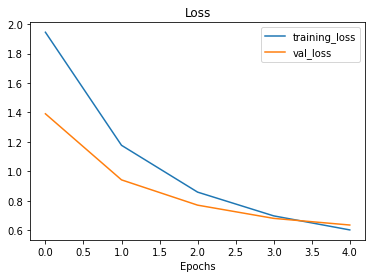

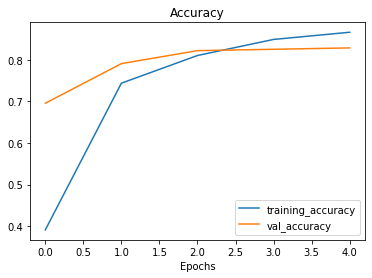

In [16]:
plot_loss_curves(history_10_percent)

# Getting a feature vector from a trained model

demonstration of GlobalAveragePooling2D layer :

we have a tensor after our model goes trough 'base' of shape (None , 7, 7, 1280), then turn into (None, 1280) after passing trough GlobalAveragePooling2D.

In [17]:
input_shape = (1, 4, 4, 3)
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
input_tensor

<tf.Tensor: shape=(1, 4, 4, 3), dtype=float32, numpy=
array([[[[ 0.3274685 , -0.8426258 ,  0.3194337 ],
         [-1.4075519 , -2.3880599 , -1.0392479 ],
         [-0.5573232 ,  0.539707  ,  1.6994323 ],
         [ 0.28893656, -1.5066116 , -0.26454744]],

        [[-0.59722406, -1.9171132 , -0.62044144],
         [ 0.8504023 , -0.40604794, -3.0258412 ],
         [ 0.9058464 ,  0.29855987, -0.22561555],
         [-0.7616443 , -1.891714  , -0.9384712 ]],

        [[ 0.77852213, -0.47338897,  0.97772694],
         [ 0.24694404,  0.20573747, -0.5256233 ],
         [ 0.32410017,  0.02545409, -0.10638497],
         [-0.6369475 ,  1.1603122 ,  0.2507359 ]],

        [[-0.41728497,  0.40125778, -1.4145442 ],
         [-0.59318566, -1.6617213 ,  0.33567193],
         [ 0.10815629,  0.2347968 , -0.56668764],
         [-0.35819843,  0.88698626,  0.5274477 ]]]], dtype=float32)>

In [19]:
global_avg_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
global_avg_pooled_tensor, input_tensor.shape, global_avg_pooled_tensor.shape

(<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>,
 TensorShape([1, 4, 4, 3]),
 TensorShape([1, 3]))

from (1, 4, 4, 3) to (1, 3).

it did so by averaging the input_tensor across the middle two axes.

In [20]:
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

Doing this not only makes the output of the base model compatible with the input shape requirement of our output layer (tf.keras.layers.Dense()), it also condenses the information found by the base model into a lower dimension feature vector.

# Transfer Learning experiments

we have made a model trained with 10% data, but lets try with 1% we can expect faster training, but is it going to perform well? also other model :

- model1 : feature extraction with 1% data, augmented
- model2 : feature extraction with 10% data, augmented
- model3 : fine tune on 10% training data, augmented
- model4 : fine tune on 100% training data, augmented

In [21]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2021-05-23 11:46:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 2607:f8b0:4023:c06::80, 2607:f8b0:4023:c0b::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   221MB/s    in 0.6s    

2021-05-23 11:46:35 (221 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [22]:
# Walk through 1 percent data directory and list number of files
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There a

In [23]:
import tensorflow as tf
imgsize = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=imgsize)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=imgsize)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Loaded, lets augment it.

# adding data augmentation layer right into the model

rather than augmenting the data before feeding the data into the model, we can integrate the augmentation process right into the model using the tf.keras.layers.experimental.preprocessing module and creating a dedicated data augmentation layer.

In [24]:
#build augmentation layer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

lets test it before moving on

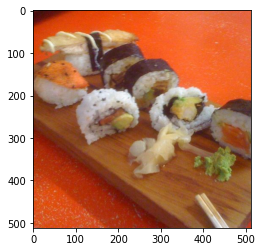

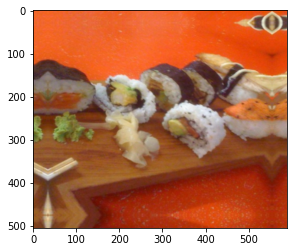

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation

# model1: feature extraction on 1% of the data with augmentation

In [27]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20210523-121552
Epoch 1/5
3/3 [==============================] - 44s 18s/step - loss: 2.4619 - accuracy: 0.1073 - val_loss: 2.2201 - val_accuracy: 0.1908
Epoch 2/5
3/3 [==============================] - 38s 18s/step - loss: 2.1836 - accuracy: 0.2386 - val_loss: 2.0969 - val_accuracy: 0.2664
Epoch 3/5
3/3 [==============================] - 38s 18s/step - loss: 1.9915 - accuracy: 0.2867 - val_loss: 2.0050 - val_accuracy: 0.3240
Epoch 4/5
3/3 [==============================] - 38s 18s/step - loss: 1.8024 - accuracy: 0.5683 - val_loss: 1.9036 - val_accuracy: 0.4030
Epoch 5/5
3/3 [==============================] - 38s 18s/step - loss: 1.6251 - accuracy: 0.6040 - val_loss: 1.8104 - val_accuracy: 0.4539


In [28]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [30]:
model_1.evaluate(test_data)

79/79 [==============================] - 135s 2s/step - loss: 1.7998 - accuracy: 0.4576


[1.7998404502868652, 0.4575999975204468]

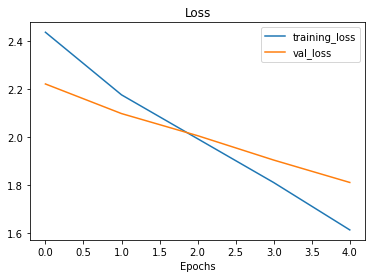

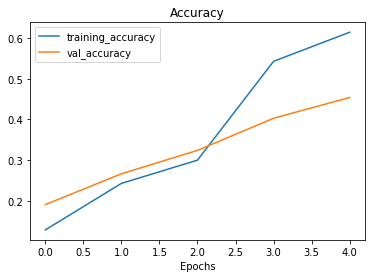

In [29]:
plot_loss_curves(history_1_percent)

with only 7 training data, the model performed about the same as our first ever model that use 750 training data.

this can only get better as we add more data to it.

#Model2: Feature extraction transfer learning with 10% of data and data augmentation

In [31]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [32]:
import tensorflow as tf
imgsize = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=imgsize)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=imgsize)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


lets re-create the model, nothing changes.

In [38]:
from tensorflow.keras.models import Sequential
# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet                 
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# freeze basemodel
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so it wont get updated
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.001),
              metrics=["accuracy"])

#CheckPoint Callbacks

checkpoint callbacks will saved the model on every X epochs.

this will be useful for training a model that takes a long time, a saved model also can be trained later on.

In [39]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

now we have tensorboard to track our experiment, and checkpoint to save the model

In [40]:
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), 
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20210523-123024
Epoch 1/5
24/24 [==============================] - 86s 3s/step - loss: 2.2274 - accuracy: 0.1836 - val_loss: 1.5429 - val_accuracy: 0.6069

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 78s 3s/step - loss: 1.4954 - accuracy: 0.6201 - val_loss: 1.1093 - val_accuracy: 0.7566

Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 79s 3s/step - loss: 1.1200 - accuracy: 0.7492 - val_loss: 0.8838 - val_accuracy: 0.7928

Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 80s 3s/step - loss: 0.9451 - accuracy: 0.7744 - val_loss: 0.8084 - val_accuracy: 0.7977

Epoch 00004: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24/24 [====

In [41]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 136s 2s/step - loss: 0.7044 - accuracy: 0.8056


[0.7044397592544556, 0.8055999875068665]

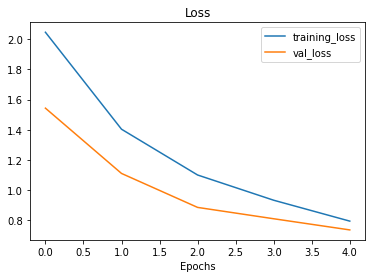

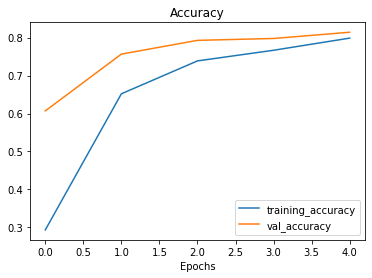

In [42]:
plot_loss_curves(history_10_percent_data_aug)

This model did not perform as well as the 10% non augmented model, however the curves are heading into better direction compared to model0.

we have saved the best weights, lets load it then evaluate it.

In [43]:
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 136s 2s/step - loss: 0.7044 - accuracy: 0.8056


In [44]:
results_10_percent_data_aug == loaded_weights_model_results

False

If the above cell doesn't output True, it's because the numbers are close but not the exact same (due to how computers store numbers with degrees of precision).

In [46]:
import numpy as np
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[0. 0.]


the difference are very miniscule, it basically same model

# Model3 : Fine Tuning existing model on 10% data
previously, what we did is freezing the existing model as whole and adding layer on top of it, now we only freeze portion of it, so we can train the unfreezed layer.

In [47]:
model_2.layers

In [48]:
for layer in model_2.layers:
  print(layer.trainable)

True
True
False
True
True


In [49]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [51]:
# How many layers are trainable in our base model?
print(len(model_2.layers[2].trainable_variables)) # layer at index 2 is the EfficientNetB0 layer (the base model)

0


In [52]:
print(len(base_model.trainable_variables))

0


there are 0 trainable layers because we froze the whole model

we are going to make the last 10 layer before output to be trainable, so it weights can be updated when we fit the model.

to begin, lets unfreeze the whole base model, then freeze every layer except the last 10.

In [53]:
base_model.trainable = True

# Freeze all layers except for last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), # lr is 10x lower than before for fine-tuning so unfreezed layer dont get updated too much resulting in overfitting
              metrics=["accuracy"])

In [54]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [55]:
print(len(model_2.trainable_variables))

12


good, we have 1 trainable input layer, 10 layers in base, 1 on output, now we have 12 trainable layer

In [56]:
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20210523-130051
Epoch 5/10
24/24 [==============================] - 90s 4s/step - loss: 0.7202 - accuracy: 0.8092 - val_loss: 0.5459 - val_accuracy: 0.8421
Epoch 6/10
24/24 [==============================] - 85s 4s/step - loss: 0.5729 - accuracy: 0.8259 - val_loss: 0.5338 - val_accuracy: 0.8191
Epoch 7/10
24/24 [==============================] - 84s 4s/step - loss: 0.5069 - accuracy: 0.8446 - val_loss: 0.5302 - val_accuracy: 0.8257
Epoch 8/10
24/24 [==============================] - 83s 3s/step - loss: 0.4729 - accuracy: 0.8832 - val_loss: 0.5568 - val_accuracy: 0.8059
Epoch 9/10
24/24 [==============================] - 82s 3s/step - loss: 0.3783 - accuracy: 0.9096 - val_loss: 0.5064 - val_accuracy: 0.8388
Epoch 10/10
24/24 [==============================] - 83s 3s/step - loss: 0.3800 - accuracy: 0.8829 - val_loss: 0.5306 - val_accuracy: 0.8240


In [57]:
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 138s 2s/step - loss: 0.5157 - accuracy: 0.8256


# Evaluate

In [58]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.2933333218097687, 0.6520000100135803, 0.7386666536331177, 0.7666666507720947, 0.7986666560173035, 0.800000011920929, 0.8226666450500488, 0.846666693687439, 0.8773333430290222, 0.890666663646698, 0.8866666555404663]


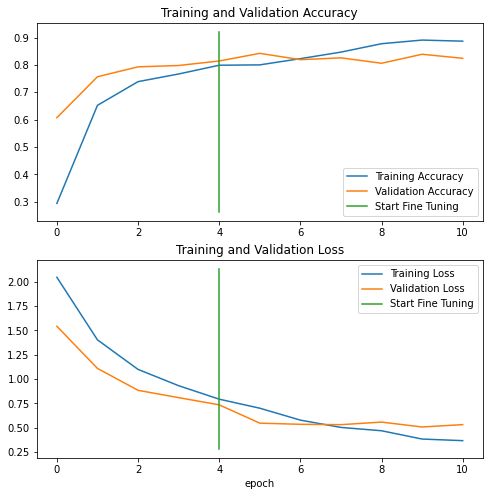

In [59]:
compare_historys(original_history=history_10_percent_data_aug, 
                 new_history=history_fine_10_percent_data_aug, 
                 initial_epochs=5)

#Model4: Fine-tuning an existing model all of the data

In [60]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2021-05-23 13:14:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 2607:f8b0:4023:c03::80, 2607:f8b0:4023:c0b::80
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   239MB/s    in 2.1s    

2021-05-23 13:14:11 (239 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [61]:
import tensorflow as tf
imgsize = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=imgsize)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=imgsize)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


just to remember what is the performance of our previous model, lets run evaluation again

In [62]:
model_2.evaluate(test_data)

79/79 [==============================] - 138s 2s/step - loss: 0.5157 - accuracy: 0.8256


[0.5157129764556885, 0.8256000280380249]

In [63]:
results_fine_tune_10_percent

[0.5157129764556885, 0.8256000280380249]

In [64]:
# Load model from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path) # revert model back to saved weights

In [65]:
model_2.evaluate(test_data) #after we load the weight, the model has the weights before fine tuned. look at the code we dont write modelchekpoint callbacks in there

79/79 [==============================] - 138s 2s/step - loss: 0.7044 - accuracy: 0.8056


[0.704439640045166, 0.8055999875068665]

In [66]:
# Check to see if the above two results are the same (they should be)
results_10_percent_data_aug

[0.7044397592544556, 0.8055999875068665]

Alright, the previous steps might seem quite confusing but all we've done is:

- Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using ModelCheckpoint.
- Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen.
- Saved the results and training logs each time.
- Reloaded the model from 1 to do the same steps as 2 but with all of the data.
The same steps as 2?

Yeah, we're going to fine-tune the last 10 layers of the base model with the full dataset for another 5 epochs but first let's remind ourselves which layers are trainable.

In [67]:
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [68]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), # divide learning rate by 10 for fine-tuning
                metrics=["accuracy"])

In [71]:
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full, #full data this time
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20210523-132333
Epoch 5/10
235/235 [==============================] - 521s 2s/step - loss: 0.8021 - accuracy: 0.7481 - val_loss: 0.4041 - val_accuracy: 0.8651
Epoch 6/10
235/235 [==============================] - 516s 2s/step - loss: 0.6023 - accuracy: 0.8046 - val_loss: 0.3482 - val_accuracy: 0.8947
Epoch 7/10
235/235 [==============================] - 519s 2s/step - loss: 0.5470 - accuracy: 0.8287 - val_loss: 0.3544 - val_accuracy: 0.8832
Epoch 8/10
235/235 [==============================] - 516s 2s/step - loss: 0.4965 - accuracy: 0.8429 - val_loss: 0.2958 - val_accuracy: 0.9030
Epoch 9/10
235/235 [==============================] - 521s 2s/step - loss: 0.4618 - accuracy: 0.8523 - val_loss: 0.3180 - val_accuracy: 0.9030
Epoch 10/10
235/235 [==============================] - 514s 2s/step - loss: 0.4213 - accuracy: 0.8640 - val_loss: 0.3065 - val_accuracy: 0.9112


In [72]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 139s 2s/step - loss: 0.3029 - accuracy: 0.9004


[0.3028790354728699, 0.9003999829292297]

5
11
[0.2933333218097687, 0.6520000100135803, 0.7386666536331177, 0.7666666507720947, 0.7986666560173035, 0.7656000256538391, 0.7994666695594788, 0.8254666924476624, 0.8377333283424377, 0.8551999926567078, 0.8590666651725769]


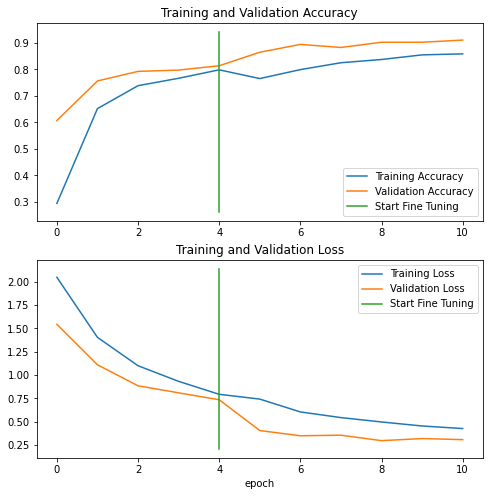

In [73]:
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

view experiment on tensor board

In [74]:
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer learning experiments" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot

2021-05-23 14:17:42.595641: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3